# Pose Estimation

**What is pose estimation**
Pose estimation predicts different poses based on a person’s body parts and joint positioning in an image or video. We can automatically detect the joints, arms, hips, and spine position while performing a squat.

Use cases:
- Athlete rehabilitating after an injury or undergoing strength training; the pose estimation may help sports analysts analyze vital points from the starting position to the end position of a squat

### MediaPipe Github: https://github.com/google/mediapipe


Follow along from the video to get up and running:

https://www.youtube.com/watch?v=SSW9LzOJSus

## PoseNet vs OpenPose comparrisons

https://medium.com/augmented-startups/top-9-pose-estimation-models-of-2022-70d00b11db43

In [1]:
# %matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
# Imports
import os
import math
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt

from dtaidistance import dtw
from os import listdir
from os.path import isfile, join
import itertools

In [3]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

mp_pose = mp.solutions.pose
mp_holistic = mp.solutions.holistic

POSE_LANDMARKS = [m.name for m in mp_pose.PoseLandmark]

In [4]:
def calc_angle_in_3d_space(a, b, c):  
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    
    v1 = np.array([ a[0] - b[0], a[1] - b[1], a[2] - b[2] ])
    v2 = np.array([ c[0] - b[0], c[1] - b[1], c[2] - b[2] ])

    v1mag = np.sqrt([ v1[0] * v1[0] + v1[1] * v1[1] + v1[2] * v1[2] ])
    v1norm = np.array([ v1[0] / v1mag, v1[1] / v1mag, v1[2] / v1mag ])

    v2mag = np.sqrt(v2[0] * v2[0] + v2[1] * v2[1] + v2[2] * v2[2])
    v2norm = np.array([ v2[0] / v2mag, v2[1] / v2mag, v2[2] / v2mag ])
    res = v1norm[0] * v2norm[0] + v1norm[1] * v2norm[1] + v1norm[2] * v2norm[2]
    angle_rad = np.arccos(res)
    
    if angle_rad > np.pi:
        angle_rad = 2*np.pi - angle_rad

    return math.degrees(angle_rad)


def calc_angle_in_2d_space(a, b, c):  
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    radians = np.abs(radians)
    
    if radians > np.pi:
        angle_rad = 2*np.pi - angle_rad

    return np.degrees(radians)


def get_coords_from_landmark(landmark):
    return (landmark.x, landmark.y)



def get_filenames_in_folder(folder_path: str):

    onlyfiles = [f for f in listdir(folder_path) if isfile(join(folder_path, f))]
    return onlyfiles


def compare_3d_poses(landmark_a, landmark_b):
    model_a_points = [[f.x, f.y, f.z] for f in landmark_a]
    model_b_points = [[f.x, f.y, f.z] for f in landmark_b]

    kp_avg_dist = {}

    for kp_a, kp_b, kp_label in zip(model_a_points, model_b_points, POSE_LANDMARKS):
        # print("kp_a", kp_a)
        # print("kp_b", kp_b)
        dist = dtw.distance(kp_a, kp_b)
        # print(f"kp_label: {kp_label}. Dist = {dist:.3f}")
        kp_avg_dist[kp_label] = dist


    kp_total_dist = np.mean(list(kp_avg_dist.values()))      
    return kp_total_dist



def plot_and_compare_images(images):
    result_arr = []

    # Run MediaPipe Pose and plot 3d pose world landmarks.
    with mp_holistic.Holistic(
        static_image_mode=True, min_detection_confidence=0.75, model_complexity=2, 
    ) as pose:
        for img in images:


            results = pose.process(img)
            result_arr.append(results)
            mp_drawing.plot_landmarks(results.pose_world_landmarks,  mp_pose.POSE_CONNECTIONS)
            # plt.xlabel('X')
            # plt.ylabel('Y')
            # plt.zlabel('Z')
            # plt.show()
    
    
    agg_dist_arr = []
    # All pairwise comparissons
    landmarks = [l.pose_world_landmarks.landmark for l in result_arr]
    for landmark_a, landmark_b in itertools.combinations(landmarks, 2):
        kp_total_dist = compare_3d_poses(landmark_a, landmark_b)
        agg_dist_arr.append(kp_total_dist)
        print("kp_total_dist", kp_total_dist) 

    agg_dist = np.mean(agg_dist_arr)
    print(f"agg_dist: {agg_dist:.3f}")

## Initilize webcame

In [5]:

# from dtaidistance import dtw

# timeseries = []
# ds = dtw.distance_matrix_fast(points, parallel=True)
# ds

In [6]:
# avg_ds = np.mean(ds, axis=-1)
# avg_ds

In [7]:
# # Apply this to a video

# # We need to create array of (x, y, z) points across frames for a given keypoint:


# video_a_dict[Nose] = [(x1,y1,z1), (x2,y2,z2), ..., (xN,yN,zN)]
# video_a_dict[ELBOW] = [(x1,y1,z1), (x2,y2,z2), ..., (x_N,y_N,z_N)]

# Then we can use the distance comparrision across these arrays

In [8]:
a = [1,2,1,1,1,3,4,1,1,1]
b = [1,2,1,3,4,1]

dtw.distance(a, b)

0.0

## Load in video

In [9]:
golf_side_slow_video_dir = "./inputs/golf/side_angle/slow/"
vids = get_filenames_in_folder(golf_side_slow_video_dir)
print("vids", vids)

video_path = os.path.join(golf_side_slow_video_dir, vids[0])
video_path

vids ['side_slow_1.mp4', 'side_slow.mp4']


'./inputs/golf/side_angle/slow/side_slow_1.mp4'

In [10]:
def display_video(video_path):

    video = cv2.VideoCapture(video_path)

    while video.isOpened():

        # Capture the video frame by frame
        ret, frame = video.read()

        if frame is None:
            # After the loop release the cap object
            video.release()
            # Destroy all the windows
            cv2.destroyAllWindows()
            break

        img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # Display on image feed
        cv2.imshow('Holistic Pose Estimation Feed', img_rgb)

        # Press 'q' to close the videp
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break



In [11]:
# display_video(video_path)

In [12]:
golf_side_slow_video_dir = "./inputs/golf/side_angle/fast/"
input_folder = golf_side_slow_video_dir

file_names = get_filenames_in_folder(input_folder)
images = []

for name in file_names:
    print(f"Video: {name}")
    # file_path = os.path.join(pose_folder, name)
    # image = cv2.cvtColor(cv2.imread(file_path), cv2.COLOR_BGR2RGB)
    # images.append(image)
    # plt.imshow(image)
    # plt.show()


# plot_and_compare_videos(images)

Video: side_fast_cropped.mp4
Video: side_fast_3.mp4
Video: side_fast.mp4
Video: side_fast_2.mp4


## Single video - to 3d Moving map

In [13]:
video = file_names[-1]
vid_path = os.path.join(input_folder, video)
vid_path

'./inputs/golf/side_angle/fast/side_fast_2.mp4'

In [ ]:
# Load in single vide images
video_stream = cv2.VideoCapture(vid_path)

result_arr = []
stream_counter = 0

# Run MediaPipe Pose and plot 3d pose world landmarks.
with mp_holistic.Holistic(
    static_image_mode=True, min_detection_confidence=0.5, model_complexity=1, 
) as pose:

    while video_stream.isOpened():
        # Capture the video frame by frame
        ret, frame = video_stream.read()

        if frame is None:
            break
            
        # stream_counter += 1
        # if not stream_counter % 5 == 0:
        #     continue

        img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        results = pose.process(img_rgb)
        result_arr.append({
            "results":results,
            "img_rgb": img_rgb
        })
        # mp_drawing.plot_landmarks(results.pose_world_landmarks,  mp_pose.POSE_CONNECTIONS)
        

        # Display on image feed
        # cv2.imshow('Holistic Pose Estimation Feed', img_rgb)

        # Press 'q' to close the videp
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

# Once we Break - Hit this
# After the loop release the cap object and Destroy all the windows
video_stream.release()
cv2.destroyAllWindows()


# agg_dist_arr = []
# # All pairwise comparissons
# landmarks = [l.pose_world_landmarks.landmark for l in result_arr]
# for landmark_a, landmark_b in itertools.combinations(landmarks, 2):
#     kp_total_dist = compare_3d_poses(landmark_a, landmark_b)
#     agg_dist_arr.append(kp_total_dist)
#     print("kp_total_dist", kp_total_dist) 

# agg_dist = np.mean(agg_dist_arr)
# print(f"agg_dist: {agg_dist:.3f}")

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [ ]:
len(result_arr)

221

In [ ]:
# result.pose_world_landmarks.landmark

In [ ]:
# pose_coords_3d = np.array([[(f.x, f.y, f.z) for f in result.pose_world_landmarks.landmark]]).squeeze()
# # pose_coords_2d = pose_coords_3d[:,0:2]

# x, y, c = img.shape
# shaped = np.squeeze(np.multiply(pose_coords_3d, [y, x, 1]))
# shaped

NameError: name 'img' is not defined

In [ ]:
# fig, ax = plt.subplots(1,1, figsize=(8,8))
# ax.imshow(img)

In [ ]:
# frame = img.copy()
# confidence_threshold = 0

# pose_coords_3d = np.array([[(f.x, f.y, f.visibility) for f in result.pose_world_landmarks.landmark]]).squeeze()
# # pose_coords_2d = pose_coords_3d[:,0:2]

# x, y, c = frame.shape
# shaped = np.squeeze(np.multiply(pose_coords_3d, [y, x, 1]))

# for kp in shaped:    
#     ky, kx, kp_coef = kp
#     if kp_coef > confidence_threshold:
#         cv2.circle(frame, (int(kx), int(ky)), 4, (0, 255, 0), -1)
#         print(kp)

In [ ]:
plt.imshow("Test 1", frame)

In [24]:
def render_keypoints(frame, pose_world_landmarks, confidence_threshold: float = 0.5):
    pose_coords_3d = np.array([[(f.x, f.y, f.visibility) for f in result.pose_world_landmarks.landmark]]).squeeze()
    # pose_coords_2d = pose_coords_3d[:,0:2]

    x, y, c = frame.shape
    shaped = np.multiply(pose_coords_3d, [x, y, 1])

    for kp in shaped:    
        ky, kx, kp_coef = kp
        if kp_coef > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 4, (0, 255, 0), -1)
            print(kp)

[-18.70337725 -73.59286785   0.99968231]
[-18.82536292 -80.5949688    0.99909914]
[-18.7706542  -80.64763069   0.99917501]
[-18.75124335 -80.72208405   0.99933356]
[-23.28788519 -78.58706951   0.99903095]
[-23.19824696 -78.76178265   0.99896002]
[-23.2488966  -78.9936161    0.99906582]
[ -7.43813336 -85.11306763   0.99869895]
[-27.22172737 -78.49927425   0.99728298]
[-12.36551762 -72.63623238   0.99959105]
[-18.22274089 -70.42599678   0.99934489]
[ 15.37436843 -62.57679462   0.99995863]
[-29.03474569 -57.46732712   0.99991536]
[ 13.32519412 -23.11987877   0.98758984]
[-22.75599718 -11.59839749   0.88099188]
[4.51837242 8.28923345 0.95971602]
[-14.91995335  23.34688187   0.89223462]
[ 3.17958504 20.44583321  0.92299694]
[-12.01444626  36.94254875   0.83285493]
[-1.97591558 19.56707954  0.92456859]
[-10.45869708  34.81380224   0.8326236 ]
[ 1.6699639  10.28239369  0.87917596]
[-12.29017377  25.38303375   0.79686397]
[17.27950335  0.15532847  0.99965394]
[-17.34376073  -0.28083336   0.999

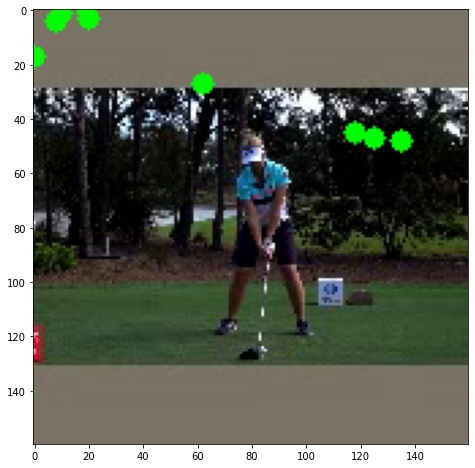

In [25]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

for result_ in result_arr:
    result, img = result_["results"], result_["img_rgb"] 
    
    render_keypoints(img, result.pose_world_landmarks)
    
    ax.imshow(img)
    # print("result", result)
    
    plt.show()
    break

In [23]:
img.shape

(160, 160, 3)

In [ ]:
video_stream = cv2.VideoCapture(vid_path)

# Run MediaPipe Pose and plot 3d pose world landmarks.
with mp_holistic.Holistic(
    static_image_mode=True, min_detection_confidence=0.5, model_complexity=1, 
) as pose:

    while video_stream.isOpened():
        # Capture the video frame by frame
        ret, frame = video_stream.read()

        if frame is None:
            break
            
        # stream_counter += 1
        # if not stream_counter % 5 == 0:
        #     continue

        img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)


        results = pose.process(img_rgb)
        result_arr.append(results)
        # mp_drawing.plot_landmarks(results.pose_world_landmarks,  mp_pose.POSE_CONNECTIONS)
        

        # Display on image feed
        # cv2.imshow('Holistic Pose Estimation Feed', img_rgb)

        # Press 'q' to close the videp
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break